# Face detection

## 1. Get the libraries

In [4]:
import os
import sys

import cv2
import numpy as np
from IPython import display
from openvino.runtime import Core

sys.path.append("utils")
import notebook_utils as utils

## 2. Get the model

the function "get_model" will
1. Download the model from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/)  

2. Convert it to OpenVINO (IR) format, if needed..

3. Create an OpenVINO, inference ready object based on that model


In [5]:
def get_model(base_model_dir,model_name,precision = 'FP16' ,sub_dir='intel'):
    download_command = f"omz_downloader " \
                   f"--name {model_name} " \
                   f"--output_dir {base_model_dir} " \
                   f"--precisions {precision}"
    ! $download_command
    
    # The output path for the conversion.
    converted_model_path = f"{base_model_dir}/{sub_dir}/{model_name}/{precision}/{model_name}.xml"

    if not os.path.exists(converted_model_path):
        convert_command = f"omz_converter " \
                          f"--name {model_name} " \
                          f"--download_dir {base_model_dir} " \
                          f"--precisions {precision}"
        ! $convert_command
        
    # Initialize OpenVINO Runtime.
    ie_core = Core()
    
    # Read the network and corresponding weights from a file.
    model = ie_core.read_model(model=converted_model_path)
    
    # Compile the model for CPU 
    return ie_core.compile_model(model=model, device_name="CPU")


## Face detection class.

Create a class for face detection

In [6]:
class face_detection():
    def __init__(self):
        self.compiled_model = get_model('face_detect','face-detection-adas-0001')
        
        self.output_layer = self.compiled_model.output(0)
        input_layer = self.compiled_model.input(0)
        self.height, self.width = list(input_layer.shape)[2:4]
face_det=face_detection()

'omz_downloader' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
class emotion_detection():
    def __init__(self):
        self.compiled_model = get_model('emotions_detect','emotions-recognition-retail-0003')
        
        self.output_layer = self.compiled_model.output(0)
        input_layer = self.compiled_model.input(0)
        self.height, self.width = list(input_layer.shape)[2:4]
emotion_det=emotion_detection()

'omz_downloader' is not recognized as an internal or external command,
operable program or batch file.


## process the points (x,y) of the bounding boxes

Correct small errors, stretch the box if needed
Change box points from (x,y,dx,dy) to actuall cordinates (x,y upper left,   x,y lower right) 

In [8]:
def get_points(box,bounds,stretch=0):
    #the NN can sometimes return negative numbers that makes no sense 
    box=[max(x,0) for x in box]
    
    #getting points of the ends of the box (stretching a bit)
    x1 = box[0] - stretch*box[2]
    x2 = box[0] + (1+stretch)*box[2]
    y1 = box[1] - stretch*box[3]
    y2 = box[1] + (1+stretch)*box[3]
    
    #make sure that after streching, we are still in the image boundaries..
    x1,x2=(int(min(max(x,0),bounds[1])) for x in (x1,x2))
    y1,y2=(int(min(max(y,0),bounds[0])) for y in (y1,y2))
    assert x1<=x2 and y1<=y2 
    return x1,x2,y1,y2

### Process boxes..

For each 

In [9]:
def get_boxes(frame, results, thresh=0.1):
    # The size of the original frame.
    h, w = frame.shape[:2]
    results = results.squeeze()
    boxes = []
    
    for idx, label, confidence, xmin, ymin, xmax, ymax in results:
        if label==1. and confidence>thresh:
            # Create a box with pixels coordinates from the box with normalized coordinates [0,1].
            boxes.append(
                tuple(map(int, (xmin * w, ymin * h, (xmax - xmin) * w, (ymax - ymin) * h)))
            )
    return boxes

EMOTION_NAMES=['neutral','happy','sad','surprise','anger']

def process_faces(frame, boxes):
    final_image=frame.copy()
    color = (0,200,0)
    for box in boxes:
              
        #Add another box on the final image
        x1,x2,y1,y2=get_points(box,final_image.shape[:2])
        cv2.rectangle(img=final_image, pt1=(x1,y1), pt2=(x2, y2), color=color, thickness=2)
        
        ##prepare input input image for emotion
        emotion_input = frame[y1:y2,x1:x2]     
        
        emotion_input = cv2.resize( src=emotion_input, dsize=(emotion_det.width, emotion_det.height))  
        emotion_input = emotion_input[np.newaxis].transpose([0,3,1,2])          
        
        #run emotion inference
        emotion_output = emotion_det.compiled_model([emotion_input])[emotion_det.output_layer]
        emotion_output = emotion_output.squeeze()
        index=np.argmax(emotion_output)
        
        
        cv2.putText(
            img=final_image,
            text=f"{' '}{EMOTION_NAMES[index]}",
            org=(box[0] + 10, box[1] + 30),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=frame.shape[1] / 1000,
            color=color,
            thickness=1,
            lineType=cv2.LINE_AA,
        )
        
    return final_image

## Main loop

Get a frame by frame, process it, display it.

In [10]:
# Main processing function to run object detection.
def main_loop(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Resize the image and change dims to fit neural network input.
            input_img = cv2.resize( src=frame, dsize=(face_det.width, face_det.height))
            
            # Create a batch of images (size = 1).
            input_img = input_img[np.newaxis, ...]
            input_img=np.transpose(input_img,[0,3,1,2])
            
            # performe inference, output is a [1 1 200 7] (x,y are 0-1)
           
        
            results = face_det.compiled_model([input_img])[face_det.output_layer]
           
            
            # process the boxes, scale to full image, convert to x,y,dx,dy 
            boxes = get_boxes(frame=frame, results=results)
            
            # Draw boxes on a frame.
            frame = process_faces(frame=frame, boxes=boxes)  

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run webCam

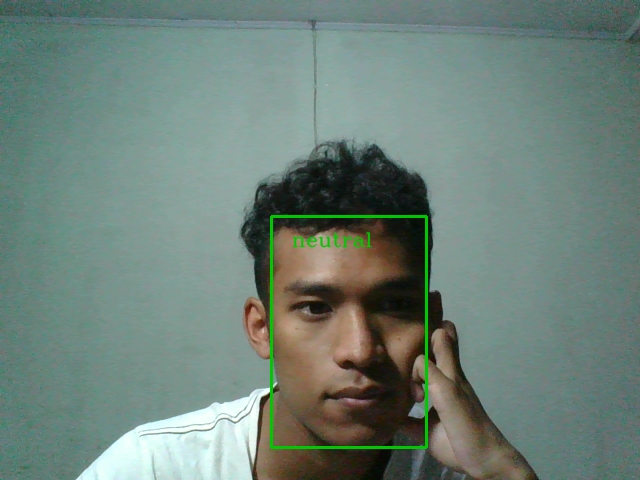

Interrupted


In [12]:
main_loop(source=0, flip=False, use_popup=False)


### Run on local video

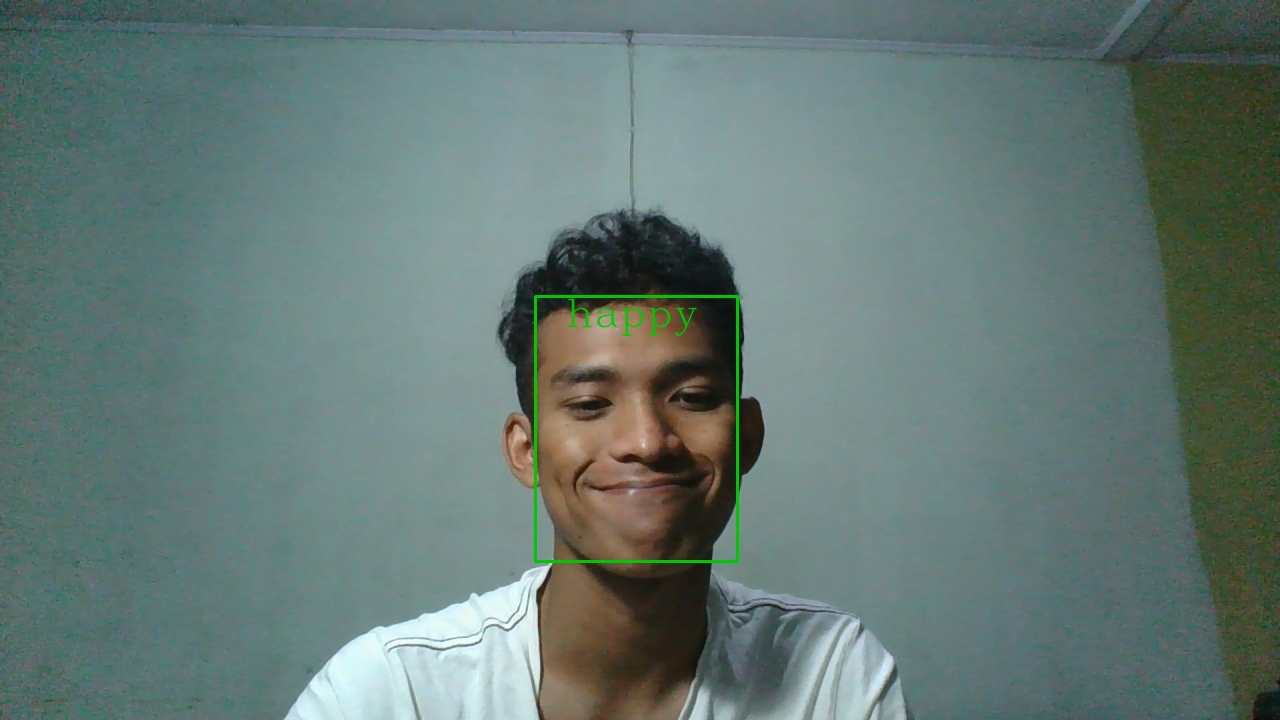

Interrupted


In [23]:
video_file='videos/my face.mp4'
main_loop(source=video_file, flip=False, use_popup=False)